# Example for interpretation via SHAP

In this notebook, we wiil show how interpret output from DSAFT model via [SHAP](https://github.com/slundberg/shap). Example includes generating synthetic dataset, training, interpretation

In [11]:
import numpy as np
import torch
import pickle
import shap

from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader

from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks.progress import ProgressBar

from tqdm.notebook import trange

from pycox import datasets

### Synthetic dataset

Dataset for simulation study was build under standard survival data setting. In this example, data is generated from non-linear relationship of 6 covariates (features) to show compatibility of DNN toward non-linear setting.

$$
\log(\text{Time}) = X_1 + 3X_2^3X_3 + X_2X_3^2 + 0\times(X_4 + X_5 + X_6) + \epsilon
$$

where $X_1,\cdots,X_6 \overset{i.i.d.}{\sim}Uniform(-3, 3)$ and $e^{\epsilon}\sim Exp(1)$.

Coeffitients for $X_4, X_5, X_6$ were set 0 to show 'automatic variable selection' of DNN architect

In [12]:
def get_surv_simul(ratio, seed, sample_size = 1000):
    
    n = sample_size
    x1 = np.random.uniform(-3, 3, size = n)
    x2 = np.random.uniform(-3, 3, size = n)
    x3 = np.random.uniform(-3, 3, size = n)
    x4 = np.random.uniform(-3, 3, size = n)
    x5 = np.random.uniform(-3, 3, size = n)
    x6 = np.random.uniform(-3, 3, size = n)
    time = np.exp(x1 + 3 * (x2**3) * x3 + x2 * (x3**2)) + np.random.exponential(1, size = n)
    cens = np.random.uniform(0, 20, size = n)
    delta = (time <= cens)*1
    y = np.min([time, cens], axis = 0)
    
    x = np.hstack((x1.reshape(-1,1), x2.reshape(-1,1), x3.reshape(-1,1),
                   x4.reshape(-1,1), x5.reshape(-1,1), x6.reshape(-1,1)))
    x = np.array(x, dtype = np.float)
    y = np.array(y.reshape(-1,1), dtype = np.float)
    delta = np.array(delta.reshape(-1,1), dtype = np.int)
        
    n = x.shape[0]
    dim = x.shape[1]
    
    np.random.seed(seed)
    indices = np.array([i for i in range(n)])
    np.random.shuffle(indices)
    train_size = int(np.round(n * ratio[0]))
    val_size = int(np.round((n - train_size) * (ratio[1] / (ratio[1] + ratio[2]))))
    test_size = n - (train_size + val_size)
    
    train_idx = indices[:train_size]
    val_idx = indices[train_size:(train_size + val_size)]
    test_idx = indices[(train_size + val_size):]
    
    x_train, y_train, delta_train = x[train_idx], y[train_idx], delta[train_idx]
    x_val, y_val, delta_val = x[val_idx], y[val_idx], delta[val_idx]
    x_test, y_test, delta_test = x[test_idx], y[test_idx], delta[test_idx]
    
    train_data = TensorDataset(torch.tensor(x_train, dtype = torch.float32),
                               torch.tensor(y_train, dtype = torch.float32),
                               torch.tensor(delta_train, dtype = torch.float32))

    val_data = TensorDataset(torch.tensor(x_val, dtype = torch.float32),
                             torch.tensor(y_val, dtype = torch.float32),
                             torch.tensor(delta_val, dtype = torch.float32))

    test_data = TensorDataset(torch.tensor(x_test, dtype = torch.float32),
                              torch.tensor(y_test, dtype = torch.float32),
                              torch.tensor(delta_test, dtype = torch.float32))

    
    # return data, label, censoring indicators into TorchDataset format
    # (to exploit PyTorch framework or Pytorch Lightning)
    return dim, train_data, val_data, test_data

### Loss functions

We have implemented 4 classes of DSAFT loss; weighted-rank estimator type, mean-absolute-error (MAE) type, root-mean-squared-error type (RMSE), and negative kernel-smoothed profile likelihood type.

In this example, we will use RMSE-type DSAFT loss.

In [13]:
def dsaft_rmse_loss(theta, durations, events):
    '''
    theta: prediction output from DNN layers
    durations: log-scaled observed time (log(Y))
    events: right-censoring-indicator (delta)
    '''
    # compute residual e_i
    e = theta.sub(durations.view(-1, 1).add(1e-32).log()).neg()
    
    # sort e_i w.r.t values and store sorted indices
    e_sorted = torch.sort(e.view(-1)).values
    e_indices = torch.sort(e.view(-1)).indices.type(torch.float32)
    
    # sort durations(log(Y)), events(delta), and theta(output from DNN) w.r.t. sorted indices of e_i
    tmp = torch.stack([e_indices, durations.view(-1), events.type(torch.float32).view(-1), theta.view(-1)], dim = 1)
    tmp = tmp[tmp[:, 0].sort()[1]]
    durations_sorted = tmp[:, 1]
    events_sorted = tmp[:, 2]
    theta_sorted = tmp[:, 3]
    
    # get risk set and removed (instances whose events had been occured)
    at_risks = (e_sorted.view(-1, 1).sub(e_sorted) <= 0).mul(1)
    removed = (e_sorted.view(-1, 1).sub(e_sorted) > 0).mul(1)
    
    # estimate survival function of e_i via KM estimator
    surv = events_sorted.div(at_risks.sum(1)).sub(1).neg().abs().mul(removed).add(at_risks).prod(dim = 1)
    
    # estimate differential of F (cumulative density function) i.e. dF(u)
    d_cdf = torch.cat([surv.sub(1).abs()[1:], torch.ones(1).to(surv.device)]).sub(surv.sub(1).abs())
    
    # evaluate conditional expectation of epsilon
    cond_E = e_sorted.mul(d_cdf).mul(at_risks).sum(dim = 1).mul(surv.reciprocal()).add(theta_sorted)
    
    # evaluate y_hat: imputed y
    imputed = events_sorted.mul(durations_sorted.add(1e-32).log().sub(cond_E)).add(cond_E)
    
    # takes MAE form rather than MSE for practically stable convergence
    loss = imputed.sub(theta_sorted).pow(2).sum().mul(1 / e_sorted.shape[0]).pow(0.5)
    
    return loss

### Model

In this example, 4-layered MLP with dropout and batch-norm was used. [PyTorch Lightning](https://github.com/PyTorchLightning/pytorch-lightning) was exploited to implement model.

In [14]:
class DeepModel_4L_testing(LightningModule):
    
    def __init__(self, dropout_rate, batch_size, loss_func, sample_size, ratio, nodes, weight_decay, seed):
        super().__init__()
        
        self.nodes = nodes
        self.weight_decay = weight_decay
        self.dropout_rate = dropout_rate
        self.batch_size = batch_size
        self.loss_func = loss_func
        self.sample_size = sample_size
        self.ratio = ratio
        self.seed = seed

        dim, train_data, val_data, test_data = get_surv_simul(self.ratio, self.seed, self.sample_size)
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        
        self.layer_1 = torch.nn.Linear(dim, self.nodes)
        self.bn_1d_1 = torch.nn.BatchNorm1d(self.nodes)
        self.do_1 = torch.nn.Dropout(self.dropout_rate)
        self.layer_2 = torch.nn.Linear(self.nodes, self.nodes)
        self.bn_1d_2 = torch.nn.BatchNorm1d(self.nodes)
        self.do_2 = torch.nn.Dropout(self.dropout_rate)
        self.layer_3 = torch.nn.Linear(self.nodes, self.nodes)
        self.bn_1d_3 = torch.nn.BatchNorm1d(self.nodes)
        self.do_3 = torch.nn.Dropout(self.dropout_rate)
        self.layer_4 = torch.nn.Linear(self.nodes, self.nodes)
        self.bn_1d_4 = torch.nn.BatchNorm1d(self.nodes)
        self.do_4 = torch.nn.Dropout(self.dropout_rate)
        self.layer_out = torch.nn.Linear(self.nodes, 1, bias = False)

    def forward(self, x):
        x = self.layer_1(x)
        x = torch.relu(x)
        x = self.bn_1d_1(x)
        x = self.do_1(x)

        x = self.layer_2(x)
        x = torch.relu(x)
        x = self.bn_1d_2(x)
        x = self.do_2(x)
        
        x = self.layer_3(x)
        x = torch.relu(x)
        x = self.bn_1d_3(x)
        x = self.do_3(x)
        
        x = self.layer_4(x)
        x = torch.relu(x)
        x = self.bn_1d_4(x)
        x = self.do_4(x)

        x = self.layer_out(x)
        return x

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), weight_decay = self.weight_decay)
    
    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size = self.batch_size)
    
    def val_dataloader(self):
        return DataLoader(self.val_data, batch_size = self.batch_size)
    
    def test_dataloader(self):
        return DataLoader(self.test_data, batch_size = self.batch_size)

    def training_step(self, batch, batch_idx):
        x, y, delta = batch
        theta = self(x)
        loss = self.loss_func(theta, y, delta)
        return {'loss': loss}
    
    def validation_step(self, batch, batch_idx):
        x, y, delta = batch
        theta = self(x)
        loss = self.loss_func(theta, y, delta)
        return {'val_loss': loss}
    
    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        return {'val_loss': avg_loss}
    
    def test_step(self, batch, batch_idx):
        x, y, delta = batch
        theta = self(x)
        loss = self.loss_func(theta, y, delta)
        return {'val_loss': loss}
    
    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        return {'val_loss_end': avg_loss}

### Training

1,000 synthetic samples were generated to train model, splitted into training / validation / test set with ratio 50% / 30% / 20%. Nodes per layer of model were set 256.

In [15]:
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 1e-8, patience = 5, mode = 'min')
bar = ProgressBar()
bar.disable()

In [16]:
dsaft = DeepModel_4L_testing(dropout_rate = 0.2, batch_size = 99999, loss_func = dsaft_rmse_loss,
                                sample_size = 1000, ratio = (0.5, 0.3, 0.2), nodes = 256,
                                weight_decay = 0.0, seed = 1905)

In [17]:
%%time
Trainer(logger = False, checkpoint_callback = False,
        callbacks = [bar], auto_select_gpus = True,
        auto_lr_find = True, max_epochs = 500, weights_summary = None).fit(dsaft)
_ = dsaft.eval()
_ = dsaft.cpu()

GPU available: True, used: False
TPU available: None, using: 0 TPU cores


AttributeError: 'tqdm_notebook' object has no attribute 'sp'

### Interpretation with SHAP

In [18]:
dim, train, val, test = get_surv_simul(sample_size = 1000, ratio = (0.5, 0.3, 0.2), seed = 1905)
test_x, test_y, test_delta = test.tensors
train_x, train_y, train_delta = test.tensors

In [19]:
e = shap.DeepExplainer(model = dsaft, data = test_x)

In [20]:
# compute SHAP score for test dataset
shap_values = e.shap_values(test_x)

In [21]:
names = ["X1", "X2", "X3", "X4", "X5", "X6"]

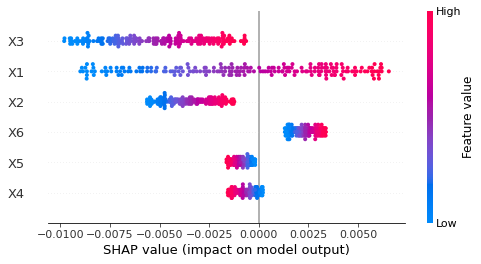

In [22]:
shap.summary_plot(shap_values, test_x, names)

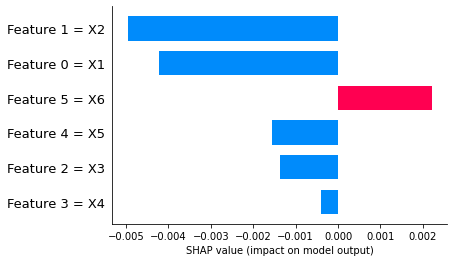

In [23]:
shap.bar_plot(shap_values[0], names)

In [24]:
test_y[0]

tensor([0.2626])

In [25]:
dsaft(test_x)[0].exp()

tensor([1.0001], grad_fn=<ExpBackward>)